In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm

dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [2]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08 and radius_EA[i]<4:
        if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3500:
            if st_eff_EA[i] < 3997:
                if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                        st_eff2.append(st_eff_EA[i])
                        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


Text(0.5, 1.0, 'STPMs Luque Improved sample')

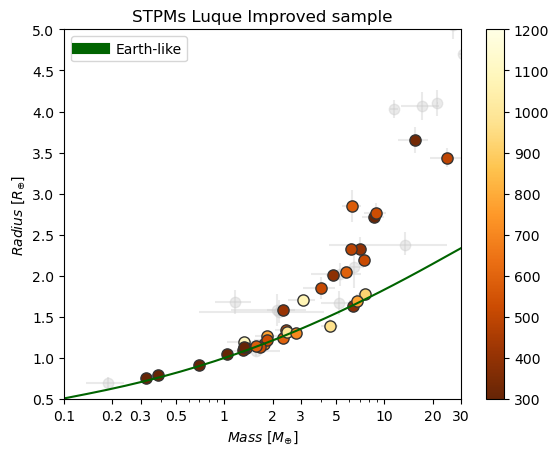

In [3]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("STPMs Luque Improved sample")

In [4]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

Text(0.5, 0, '$Mass\\ [M_{\\oplus}]$')

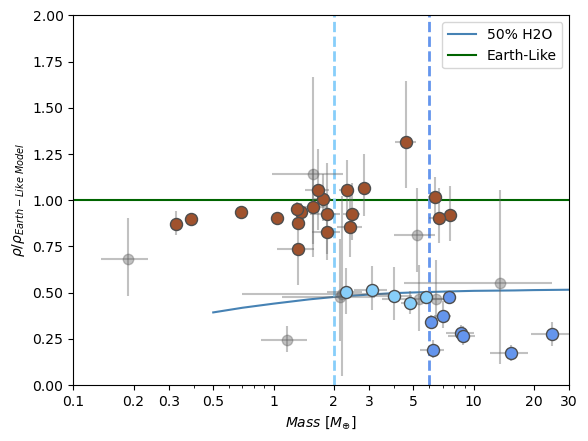

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the lines
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
mass_rocky = []; mass_water = []; mass_puffy = [];
radius_rocky = []; radius_water = []; radius_puffy = [];
density_rocky = []; density_water = []; density_puffy = [];
density_low_rocky =[]; density_low_water = []; density_low_puffy = []
density_up_rocky =[]; density_up_water = []; density_up_puffy = []
planet_rocky = []; planet_water = []; planet_puffy = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
            mass_rocky.append(mass_LI[i])
            radius_rocky.append(radius_LI[i])
            density_rocky.append(density_LI[i])
            density_low_rocky.append(density_unc_low_LI[i])
            density_up_rocky.append(density_unc_up_LI[i])
            planet_rocky.append(planet_name_LI[i])
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
            mass_puffy.append(mass_LI[i])
            radius_puffy.append(radius_LI[i])
            density_puffy.append(density_LI[i])
            density_low_puffy.append(density_unc_low_LI[i])
            density_up_puffy.append(density_unc_up_LI[i])
            planet_puffy.append(planet_name_LI[i])
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
            mass_water.append(mass_LI[i])
            radius_water.append(radius_LI[i])
            density_water.append(density_LI[i])
            density_low_water.append(density_unc_low_LI[i])
            density_up_water.append(density_unc_up_LI[i])
            planet_water.append(planet_name_LI[i])
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$")

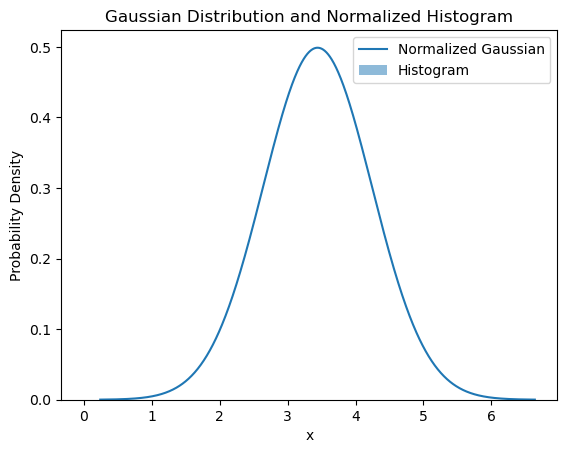

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mean = density_water[0]
std_dev_upper = density_up_water[0]
std_dev_lower = density_low_water[0]

# Calculate average standard deviation
std_dev = (std_dev_upper + std_dev_lower) / 2

# Create a range of x values
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)

# Create the Gaussian distribution
gaussian = norm.pdf(x, mean, std_dev)
area_under_curve = np.trapz(gaussian, x)
normalized_gaussian = gaussian / area_under_curve

# Specify bins
bins = np.linspace(0, 1.5, 21)

# Plot the original and normalized Gaussian distributions
plt.plot(x, normalized_gaussian, label='Normalized Gaussian')

# Create a histogram using plt.bar
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]
plt.bar(bin_centers, normalized_gaussian[:len(bins)-1], width=bin_width, alpha=0.5, label='Histogram')

plt.title('Gaussian Distribution and Normalized Histogram')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


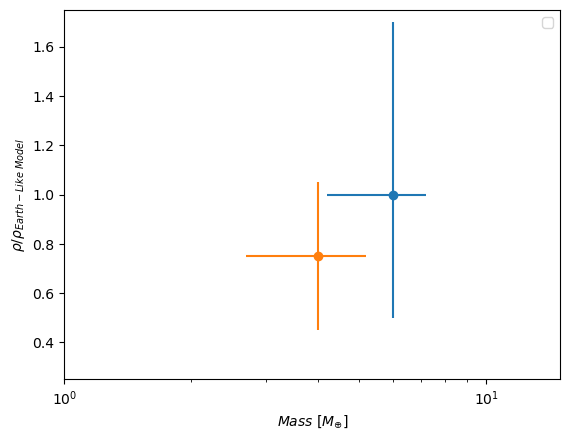

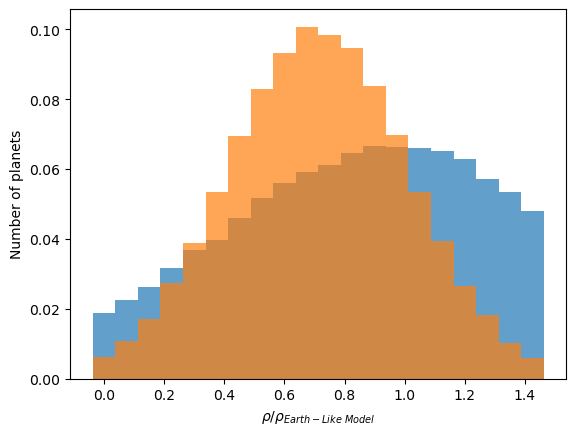

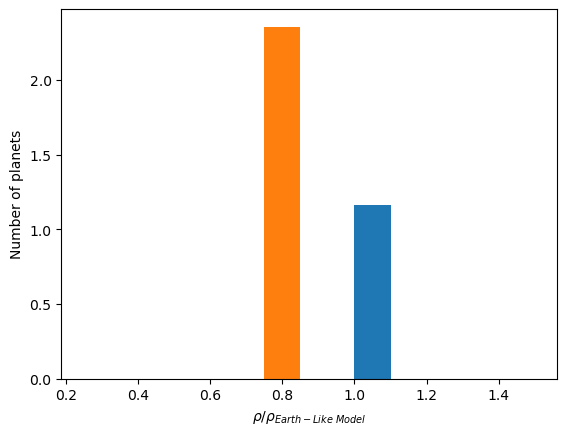

In [79]:
plt.errorbar(6,1 , xerr = [[1.8],[1.2]], yerr = [[0.5],[0.7]],marker = "o")
plt.errorbar(4,0.75 , xerr = [[1.3],[1.2]], yerr = [[0.3],[0.3]],marker = "o")
plt.ylim(0.25, 1.75); plt.xscale("log")
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.xlim(1,15)
plt.show()
mean = 1
std_dev_upper = 0.5
std_dev_lower = 0.7

std_dev = (std_dev_upper + std_dev_lower) / 2
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
gaussian = norm.pdf(x, mean, std_dev)
random_numbers = np.random.normal(mean, std_dev, 100000)
hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
scaled_hist_values = hist_values / np.sum(hist_values)
plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7)


mean = 0.75
std_dev_upper = 0.3
std_dev_lower = 0.3

std_dev = (std_dev_upper + std_dev_lower) / 2
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
gaussian = norm.pdf(x, mean, std_dev)
random_numbers = np.random.normal(mean, std_dev, 100000)
hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
scaled_hist_values = hist_values / np.sum(hist_values)
plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7)


plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel("Number of planets")
plt.show()

weight = 1/np.sqrt(0.5**2 + 0.7**2)

plt.xlabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.ylabel("Number of planets")
plt.hist([1], weights=[weight])  # Using a list with a single value for the histogram
weight = 1/np.sqrt(0.3**2 + 0.3**2)
plt.hist([0.75], weights=[weight])  # Using a list with a single value for the histogram

plt.show()


In [117]:
len(scaled_hist_values3)

20

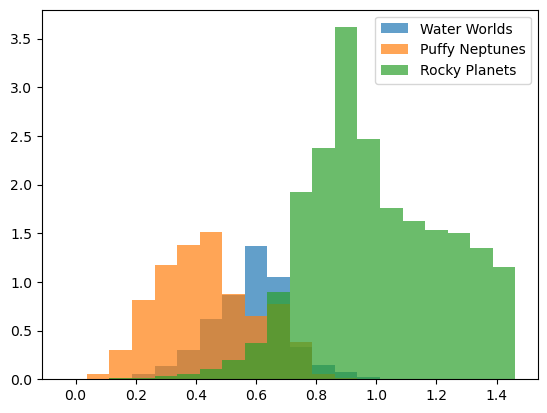

In [11]:
total_height_water  = np.zeros(len(bins)-1)
for i in range(0,len(planet_water)):
    mean = density_water[i]/earth_density
    std_dev_upper = density_up_water[i]/earth_density
    std_dev_lower = density_low_water[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 1000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_water += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

plt.bar(bin_edges[:-1], total_height_water, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Water Worlds",zorder = -21)

total_height_puffy  = np.zeros(len(bins)-1)
for i in range(0,len(planet_puffy)):
    mean = density_puffy[i]/earth_density
    std_dev_upper = density_up_puffy[i]/earth_density
    std_dev_lower = density_low_puffy[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 1000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_puffy += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

plt.bar(bin_edges[:-1], total_height_puffy, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Puffy Neptunes",zorder = -21)

total_height_rocky  = np.zeros(len(bins)-1)
for i in range(0,len(planet_rocky)):
    mean = density_rocky[i]/earth_density
    std_dev_upper = density_up_rocky[i]/earth_density
    std_dev_lower = density_low_rocky[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 1000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_rocky += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

plt.bar(bin_edges[:-1],total_height_rocky, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Rocky Planets",zorder = -21)


plt.legend()
plt.show()

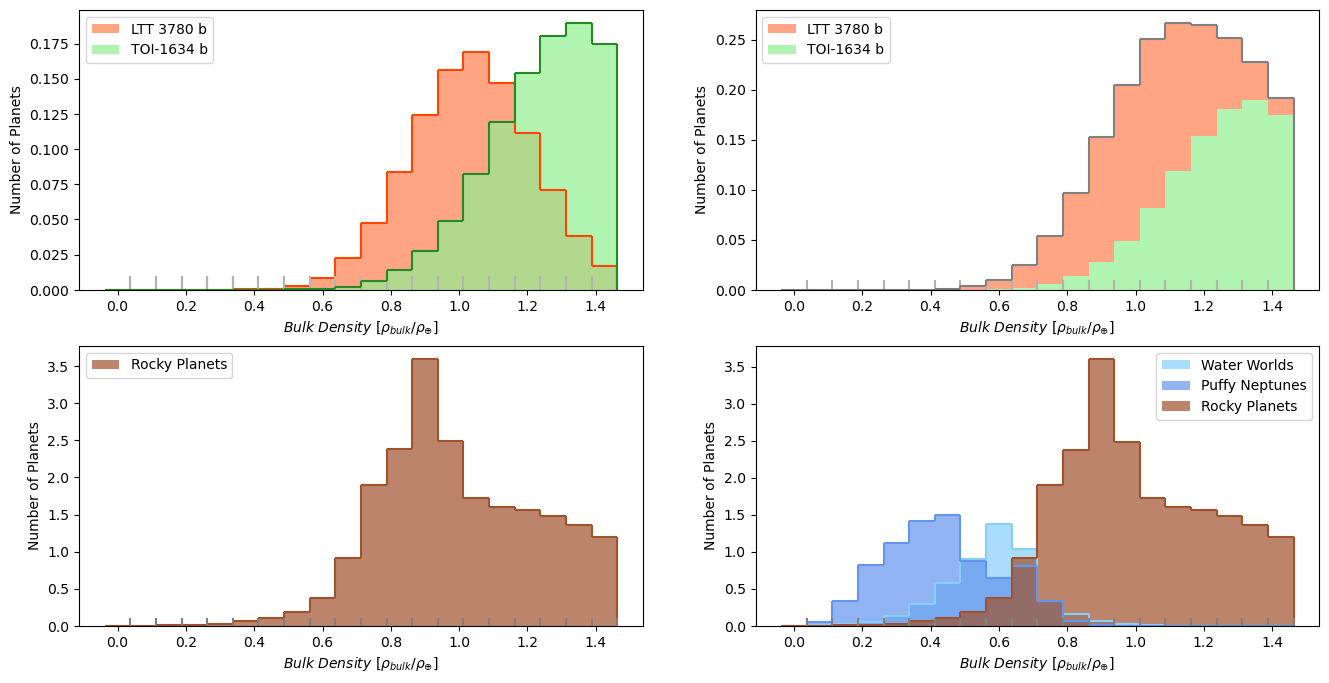

In [80]:
fig, ax = plt.subplots(figsize=(16,8))
plt.subplot(2,2,1)
total_height_rocky  = np.zeros(len(bins)-1)
for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.01,"0.8")
k =9
mean = density_rocky[k]/earth_density
std_dev_upper = density_up_rocky[k]/earth_density
std_dev_lower = density_low_rocky[k]/earth_density

std_dev = (std_dev_upper + std_dev_lower) / 2
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
gaussian = norm.pdf(x, mean, std_dev)
random_numbers = np.random.normal(mean, std_dev, 100000)
hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
scaled_hist_values1 = hist_values / np.sum(hist_values)
total_height_rocky += scaled_hist_values1
plt.bar(bin_edges[:-1], scaled_hist_values1, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_rocky[k],color = "coral")

for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,scaled_hist_values1[i],scaled_hist_values1[i+1],"orangered")
    plt.hlines(scaled_hist_values1[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,"orangered")
plt.vlines(bin_edges[19]+0.075/2,0,scaled_hist_values1[19],"orangered")
plt.hlines(scaled_hist_values1[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,"orangered")

k = 3
mean = density_rocky[k]/earth_density
std_dev_upper = density_up_rocky[k]/earth_density
std_dev_lower = density_low_rocky[k]/earth_density

std_dev = (std_dev_upper + std_dev_lower) / 2
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
gaussian = norm.pdf(x, mean, std_dev)
random_numbers = np.random.normal(mean, std_dev, 100000)
hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
scaled_hist_values2 = hist_values / np.sum(hist_values)
total_height_rocky += scaled_hist_values2
plt.bar(bin_edges[:-1], scaled_hist_values2, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_rocky[k],color = "lightgreen")

for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.01,"0.7")
for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,scaled_hist_values2[i],scaled_hist_values2[i+1],"forestgreen")
    plt.hlines(scaled_hist_values2[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,"forestgreen")
plt.vlines(bin_edges[19]+0.075/2,0,scaled_hist_values2[19],"forestgreen")
plt.hlines(scaled_hist_values2[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,"forestgreen")


plt.legend(loc=2)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")

plt.subplot(2,2,2)
k = 3
plt.bar(bin_edges[:-1], scaled_hist_values1, width=bin_edges[1] - bin_edges[0], alpha=0.7, bottom = scaled_hist_values2,label = planet_rocky[9],color = "coral")
k = 9
plt.bar(bin_edges[:-1], scaled_hist_values2, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_rocky[3],color = "lightgreen")

for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.01,"0.7")
    
for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,scaled_hist_values2[i]+scaled_hist_values1[i],scaled_hist_values2[i+1]+scaled_hist_values1[i+1],"0.5")
    plt.hlines(scaled_hist_values2[i]+scaled_hist_values1[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,"0.5")

plt.vlines(bin_edges[19]+0.075/2,0,scaled_hist_values2[19]+scaled_hist_values1[19],"0.5")
plt.hlines(scaled_hist_values2[19]+scaled_hist_values1[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,"0.5")


plt.legend(loc=2)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")


plt.subplot(2,2,3)
total_height_rocky  = np.zeros(len(bins)-1)
for i in range(0,len(planet_rocky)):
    mean = density_rocky[i]/earth_density
    std_dev_upper = density_up_rocky[i]/earth_density
    std_dev_lower = density_low_rocky[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_rocky += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

plt.bar(bin_edges[:-1],total_height_rocky, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Rocky Planets",color = "sienna",zorder = -21)
for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,total_height_rocky[i],total_height_rocky[i+1],"sienna")
    plt.hlines(total_height_rocky[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,"sienna")
plt.vlines(bin_edges[19]+0.075/2,0,total_height_rocky[19],"sienna")
plt.hlines(total_height_rocky[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,"sienna")
plt.legend(loc=2)
for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.1,"0.5",zorder = 10)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")


plt.subplot(2,2,4)
total_height_water  = np.zeros(len(bins)-1)
for i in range(0,len(planet_water)):
    mean = density_water[i]/earth_density
    std_dev_upper = density_up_water[i]/earth_density
    std_dev_lower = density_low_water[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_water += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_water, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Water Worlds",color= 'lightskyblue',zorder = -21)
for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.01,"0.4")
for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,total_height_water[i],total_height_water[i+1],"lightskyblue")
    plt.hlines(total_height_water[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,"lightskyblue")
plt.vlines(bin_edges[19]+0.075/2,0,total_height_water[19],"lightskyblue")
plt.hlines(total_height_water[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,"lightskyblue")

total_height_puffy  = np.zeros(len(bins)-1)
for i in range(0,len(planet_puffy)):
    mean = density_puffy[i]/earth_density
    std_dev_upper = density_up_puffy[i]/earth_density
    std_dev_lower = density_low_puffy[i]/earth_density
    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_puffy += scaled_hist_values

plt.bar(bin_edges[:-1], total_height_puffy, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Puffy Neptunes",color= 'cornflowerblue',zorder = -21)
for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,total_height_puffy[i],total_height_puffy[i+1],'cornflowerblue')
    plt.hlines(total_height_puffy[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,'cornflowerblue')
plt.vlines(bin_edges[19]+0.075/2,0,total_height_puffy[19],'cornflowerblue')
plt.hlines(total_height_puffy[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,'cornflowerblue')

total_height_rocky  = np.zeros(len(bins)-1)
for i in range(0,len(planet_rocky)):
    mean = density_rocky[i]/earth_density
    std_dev_upper = density_up_rocky[i]/earth_density
    std_dev_lower = density_low_rocky[i]/earth_density

    std_dev = (std_dev_upper + std_dev_lower) / 2
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100000)
    gaussian = norm.pdf(x, mean, std_dev)
    random_numbers = np.random.normal(mean, std_dev, 100000)
    hist_values, bin_edges = np.histogram(random_numbers, bins=bins, density=False)
    scaled_hist_values = hist_values / np.sum(hist_values)
    total_height_rocky += scaled_hist_values
    #plt.bar(bin_edges[:-1], scaled_hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = planet_water[i])

for i in range(0,19):
    plt.vlines(bin_edges[i]+0.075/2,total_height_rocky[i],total_height_rocky[i+1],'sienna')
    plt.hlines(total_height_rocky[i],bin_edges[i]-0.075/2,bin_edges[i]+0.075/2,'sienna')
plt.vlines(bin_edges[19]+0.075/2,0,total_height_rocky[19],'sienna')
plt.hlines(total_height_rocky[19],bin_edges[19]-0.075/2,bin_edges[19]+0.075/2,'sienna')

plt.bar(bin_edges[:-1],total_height_rocky, width=bin_edges[1] - bin_edges[0], alpha=0.7,label = "Rocky Planets",color = "sienna",zorder = -21)

for i in range(0,20):
    plt.vlines(bin_edges[i]+0.075/2,0,0.1,"0.5",zorder = 10)
plt.xlabel("$Bulk\ Density\ [ρ_{bulk}/ρ_{\oplus}]$")
plt.ylabel("Number of Planets")

plt.legend(loc=2)
plt.legend()
image_name = 'newhistograms.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)